**Note!** The generated data comes in the shape of (batch size, time series length, no. features). This means that if we want to visualize one batch of data, we do `data[0].T`. Tranpose is important to put features as rows to show multivariate data correctly!

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch as th
from pytorch_lightning import seed_everything

SEED = 42

In [2]:
import pickle
from classifier import StateClassifier, StateClassifierNet


def get_classifier(experiment):
    if experiment == "hmm":
        # From HMM experiments
        classifier = StateClassifierNet(
            feature_size=3,
            n_state=2,
            hidden_size=200,
            regres=True,
            loss="cross_entropy",
            lr=0.0001,
            l2=1e-3,
        )
        checkpoint = "../../models/hmm_42_classifier.ckpt"

        classifier.load_state_dict(th.load(checkpoint))

    return classifier


def save_explainer(explainer, explainer_name="explainer"):
    with open(f"{explainer_name}.pkl", "wb") as f:
        pickle.dump(explainer, f)


def load_explainer(explainer_name="explainer", experiment="hmm"):
    perturbation_net = None
    classifier = None

    if experiment == "hmm":
        classifier = get_classifier("hmm")
        with open(f"{explainer_name}_perturbation_net.pkl", "rb") as f:
            perturbation_net = pickle.load(f)

    with open(f"{explainer_name}_attr.pkl", "rb") as f:
        attr = pickle.load(f)

    with open(f"{explainer_name}_explainer.pkl", "rb") as f:
        ecl_inputsplainer = pickle.load(f)

    with open(f"{explainer_name}_mask_net.pkl", "rb") as f:
        mask_net = pickle.load(f)

    return attr, mask_net, ecl_inputsplainer, perturbation_net, classifier

In [3]:
# Adopted from https://github.com/fzi-forschungszentrum-informatik/TSInterpret/blob/main/TSInterpret/InterpretabilityModels/Saliency/Saliency_Base.py
def plot_saliency(ts_data, perturbed, saliency_list, figsize=None, suptitle=None):
    plt.style.use("default")

    if figsize is None:
        figsize = (10, len(ts_data) * 1.2)

    fig, axn = plt.subplots(len(ts_data), 1, sharex=True, sharey=True, figsize=figsize)
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])

    for i, channel in enumerate(ts_data):
        axn012 = axn[i].twinx()

        # Plot saliency
        sns.heatmap(
            saliency_list[i].reshape(1, -1),
            fmt="g",
            cmap="viridis",
            cbar=i == 0,
            cbar_ax=None if i else cbar_ax,
            cbar_kws={"label": "Saliency / Mask intensity"},
            ax=axn[i],
            yticklabels=False,
            vmin=0,
            vmax=1,
        )

        xs = range(0, len(channel.reshape(-1)))
        # Plot learned perturbations
        axn012.plot(
            xs,
            perturbed[i].detach().numpy(),
            color="red",
            label="Perturbed data",
            marker=".",
        )
        # Plot original data
        axn012.plot(
            xs, channel.flatten(), color="#91BBDE", label="Original data", marker="."
        )

        plt.xlabel("Time", fontweight="bold", fontsize="large")
        plt.ylabel(f"Feature {i}", fontweight="bold", fontsize="large")
    plt.legend()
    fig.tight_layout(rect=[0, 0, 0.9, 1])
    fig.suptitle(suptitle, y=1.01)
    plt.show()


# Adapted from appendix of https://arxiv.org/abs/2106.05303
def plot_heatmap(saliencies, figsize=None):
    plt.style.use("default")
    N = len(saliencies)
    if figsize is None:
        figsize = (10, N * 2)

    fig, axn = plt.subplots(
        int(np.ceil(N / 2)), 2, sharex=True, sharey=True, figsize=figsize
    )
    axn = axn.flatten()
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])

    color_map = sns.diverging_palette(10, 133, as_cmap=True)

    for idx, (method, saliency) in enumerate(saliencies.items()):
        sns.heatmap(
            saliency,
            cmap=color_map,
            cbar=idx == 0,
            cbar_ax=None if idx else cbar_ax,
            cbar_kws={"label": "Saliency / Mask intensity"},
            ax=axn[idx],
            yticklabels=False,
            linecolor="#d8cbd5",
            linewidths=0.4,
            vmin=0,
            vmax=1,
        )
        axn[idx].set_title(f"Method: {method}")
        axn[idx].set_xlabel("Time")
        axn[idx].set_ylabel("Feature number")

    fig.suptitle("Mask coefficients over time")
    fig.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

In [4]:
def plot_components(
    orig, perturbed, mask, perturbation, suptitle=None, figsize=(10, 6)
):
    plt.style.use("ggplot")
    plt.rcParams.update({"axes.titlesize": "medium"})

    fig, axs = plt.subplots(5, 1, figsize=figsize)

    orig = orig.flatten().numpy()
    perturbed = perturbed.detach().numpy()
    mask = mask.detach().numpy()
    perturbation = perturbation.detach().numpy()

    xs = range(0, len(orig.reshape(-1)))
    axs[0].plot(xs, mask, marker=".")
    axs[0].set_title("Learned mask/saliency: m")

    axs[1].plot(xs, perturbation, marker=".")
    axs[1].set_title(
        "Learned perturbation: NN(x)",
    )

    axs[2].plot(xs, mask * orig, marker=".")
    axs[2].set_title("m * x")

    axs[3].plot(xs, (1 - mask) * perturbation, marker=".")
    axs[3].set_title("(1 - m) * NN(x)")

    axs[4].plot(xs, perturbed, label="m * x + (1 - m) * NN(x)", marker=".")
    axs[4].plot(xs, orig, label="Original data", marker=".")
    axs[4].set_title("Perturbed vs Original data")
    axs[4].legend(fontsize=7)

    plt.xlabel("Time", fontweight="bold")
    plt.suptitle(suptitle)
    fig.tight_layout()
    plt.show()

In [5]:
def compute_perturbations(
    data, mask_net, perturb_net=None, batch_idx: int = 0
) -> (th.Tensor, th.Tensor, th.Tensor, th.Tensor, th.Tensor):
    """Use the trained mask network to compute perturbations and their intermediate results.

    This function only works for explainer methods that train a mask network. Such methods include DynaMask and ExtremalMask.

    :param data: all data to be investigated. A subset of it will be investigated depending on the batch_idx and batch_size of the mask_net
    :param mask_net: the trained mask network
    :param perturb_net: the trained perturbation network. You can usually access it via mask_net.net.model. Defaults to None in which case the baseline will be zeroes
    :param batch_idx: the batch number to investigate, batch size will be inferred from mask_net. Defaults to 0
    :return: a 5-tuple:
    - tensor of the batch of data that was used for calculation
    - tensor of perturbations predicted by perturb_net (or defaulted to)
    - tensor of the predicted mask by mask_net
    - tensor of inputs with important features masked, i.e. from the paper: data * mask + (1 - mask) * NN(data)
    - tensor of inputs with unimportant features masked, i.e.: data * (1 - mask) + NN(data) * data
    """

    batch_size = mask_net.net.batch_size
    FROM_B = batch_size * batch_idx
    TO_B = batch_size * (batch_idx + 1)
    batch = data[FROM_B:TO_B]

    # If there is a model, NN(x), that predicts perturbations, use it
    # Otherwise, default to zeroes
    baseline = perturb_net(batch) if perturb_net is not None else th.zeros_like(batch)

    # Retrieve the learned mask for the batch in question
    mask = mask_net.net.mask
    mask = mask[FROM_B:TO_B]
    mask = mask.clamp(0, 1)

    # Mask data according to samples
    # We eventually cut samples up to x time dimension
    # x1 represents inputs with important features masked.
    # x2 represents inputs with unimportant features masked.
    mask = mask[:, : batch.shape[1], ...]
    x1 = batch * mask + baseline * (1.0 - mask)
    x2 = batch * (1.0 - mask) + baseline * mask

    return batch, baseline.detach(), mask.detach(), x1.detach(), x2.detach()

## ARMA

In [6]:
from tint.datasets import Arma

# Make sure to seed before data generation to return numpy and other libraries to their original state
# in order to generate the same data with the same seed as the process for training the models
seed_everything(seed=SEED, workers=True)
arma = Arma(seed=SEED)
# This method generates the dataset
arma.download()
inputs_arma = arma.preprocess()["x"]
true_saliency_arma = arma.true_saliency(dim=1)
res_arma = arma.get_white_box(inputs_arma, true_saliency_arma)

/home/paulius/projects/fact/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


ARMA experiment uses a white box regressor as the main model to explain.

This means, that a number is predicted for each time series in a multivariate time series sample. 

Thus, `res_arma.size()` refers to (batch_size, no. time series in a sample).

In [7]:
# Load the models trained on ARMA data
(
    extremal_attr_arma,
    extremal_mask_net_arma,
    extremal_explainer_arma,
    _,
    _,
) = load_explainer(experiment="arma", explainer_name="../arma/extremal")

In [8]:
from tint.metrics.white_box import aup, aur, rmse, information, entropy

print(f"AUP: {aup(extremal_attr_arma, true_saliency_arma):.4}")
print(f"AUR: {aur(extremal_attr_arma, true_saliency_arma):.4}")
print(f"RMSE: {rmse(extremal_attr_arma, true_saliency_arma):.4}")
print(f"Information: {information(extremal_attr_arma, true_saliency_arma):.4}")
print(f"Entropy: {entropy(extremal_attr_arma, true_saliency_arma):.4}")

AUP: 0.9982
AUR: 0.756
RMSE: 0.1093
Information: 1.313e+06
Entropy: 3.754e+03


### Visualize explanation performance - ARMA

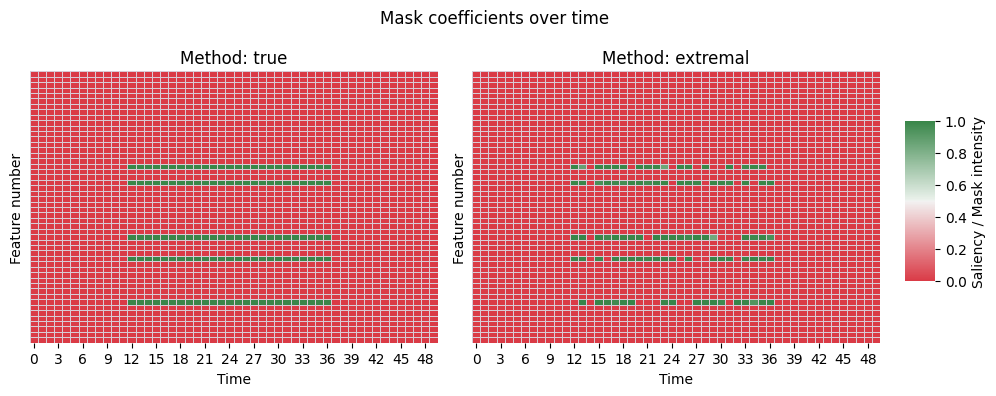

In [9]:
SAL_ID = 100  # Which sample to investigate?
saliencies = {
    "true": true_saliency_arma[SAL_ID].T,
    "extremal": extremal_attr_arma[SAL_ID].T,
}
plot_heatmap(saliencies)

### Visualize perturbations - ARMA

In [10]:
arma_batch, perturbation_arma, mask_arma, x1_arma, x2_arma = compute_perturbations(
    inputs_arma, extremal_mask_net_arma, perturb_net=None, batch_idx=0
)

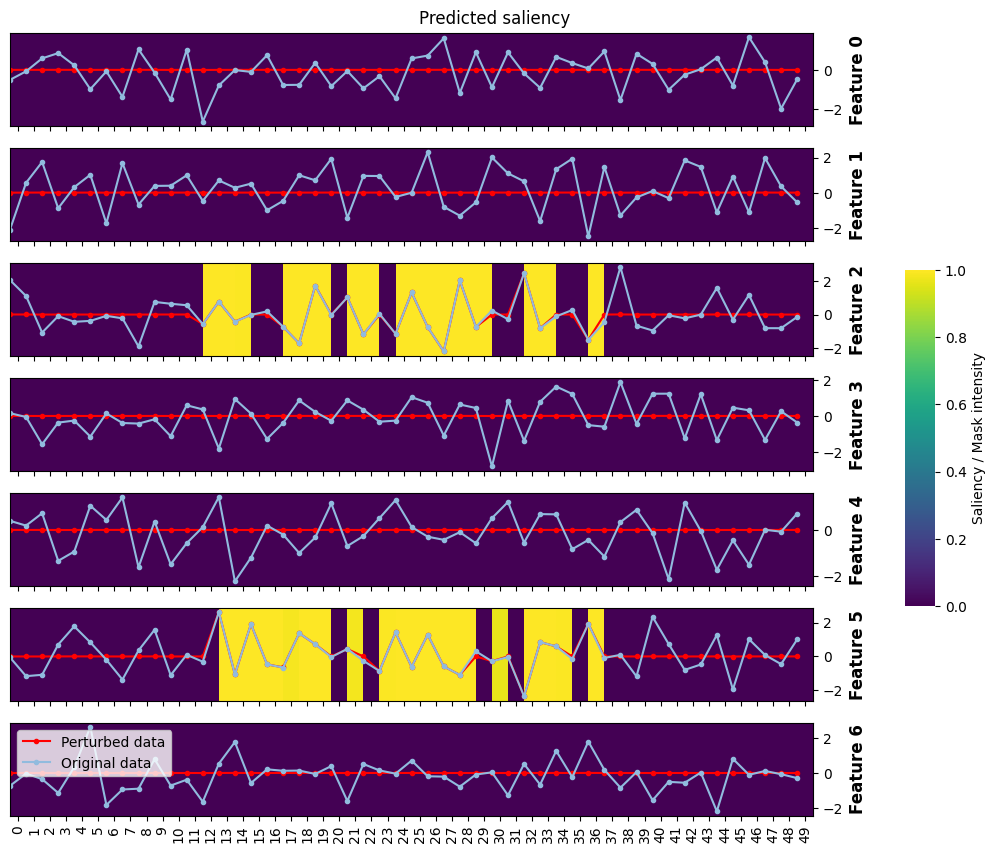

In [11]:
sample_id = 2  # Which sample to investigate?
FROM = 15  # From which time series
TO = 22  # to which time series to plot?
plot_saliency(
    arma_batch[sample_id].T[FROM:TO],
    x1_arma[sample_id].T[FROM:TO],
    mask_arma[sample_id].T[FROM:TO],
    suptitle="Predicted saliency",
)

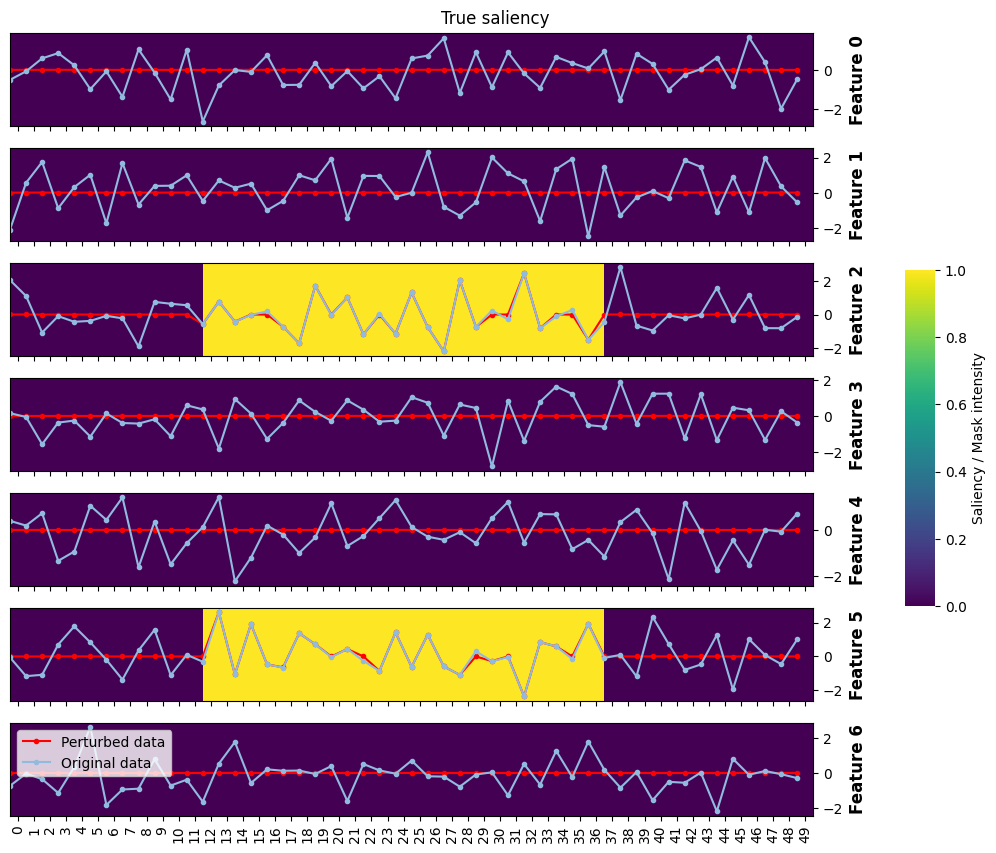

In [12]:
plot_saliency(
    arma_batch[sample_id].T[FROM:TO],
    x1_arma[sample_id].T[FROM:TO],
    true_saliency_arma[sample_id].T[FROM:TO],
    suptitle="True saliency",
)

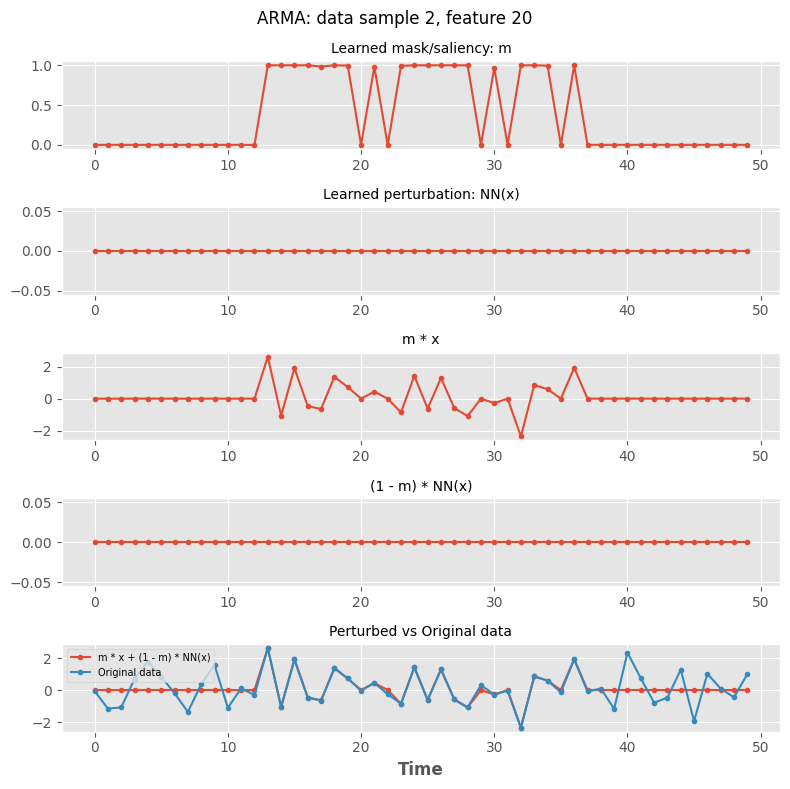

In [13]:
sample_id = 2  # Which sample to investigate?
feat_no = 20  # Which specific time series to investigate?
plot_components(
    orig=arma_batch[sample_id].T[feat_no],
    perturbed=x1_arma[sample_id].T[feat_no],
    mask=mask_arma[sample_id].T[feat_no],
    perturbation=perturbation_arma[sample_id].T[feat_no],
    suptitle=f"ARMA: data sample {sample_id}, feature {feat_no}",
    figsize=(8, 8),
)

## HMM

HMM model training and visualization procedure:
1. Retrain the networks with seed 42 and deterministic
2. Save them via pickle
3. When loading the model, make sure to 
```python
import pickle
from experiments.hmm.classifier import StateClassifier, StateClassifierNet
```

In [14]:
# Load HMM data
from tint.datasets import HMM

# Load only the test data because the classifier was trained on train part
# but the mask net and explainer was trained on the test part to explain the
# classifier's decision
# hmm.download(split="train")
# x_train = hmm.preprocess(split="train")["x"]

hmm = HMM(n_folds=5, fold=0, seed=SEED)
hmm.download(split="test")
inputs_hmm = hmm.preprocess(split="test")["x"]
y_hmm = hmm.preprocess(split="test")["y"]
true_saliency_hmm = hmm.true_saliency(split="test")
print("batch size, time series length, no. features", inputs_hmm.size())

batch size, time series length, no. features torch.Size([200, 200, 3])


In [15]:
# Load models trained on HMM data
(
    extremal_attr_hmm,
    extremal_mask_net_hmm,
    extremal_explainer_hmm,
    perturbation_net_hmm,
    classifier_hmm,
) = load_explainer(explainer_name="../../42_hmm_extremal")

# Switch to eval
classifier_hmm.eval()
print()

In [16]:
from tint.metrics.white_box import aup, aur, rmse, information, entropy

print(f"AUP: {aup(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"AUR: {aur(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"RMSE: {rmse(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Information: {information(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Entropy: {entropy(extremal_attr_hmm, true_saliency_hmm):.4}")

AUP: 0.5061
AUR: 0.4202
RMSE: 0.5561
Information: 1.61e+05
Entropy: 5.555e+03


### Visualize explanation performance - HMM

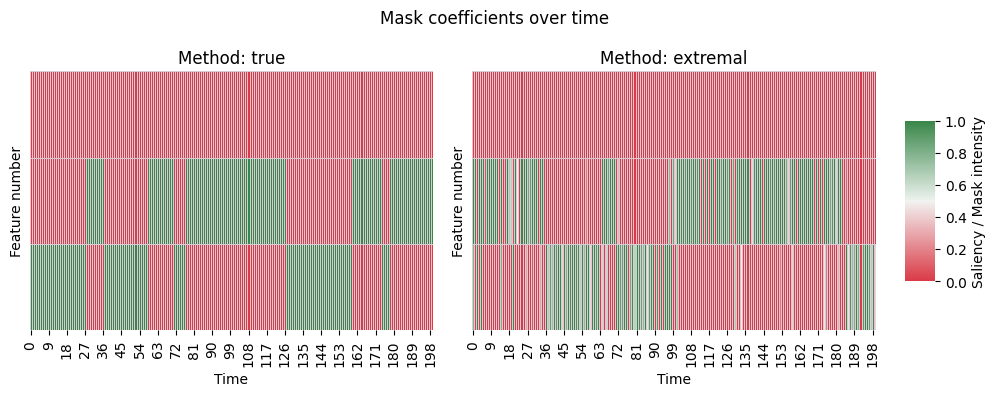

In [17]:
# Visualize true and predicted saliency
SAL_ID = 12
saliencies = {
    "true": true_saliency_hmm[SAL_ID].T,
    "extremal": extremal_attr_hmm[SAL_ID].T,
}
plot_heatmap(saliencies)

### Visualize learned perturbations - HMM

In [18]:
# x, NN(x), m, x * m + (1 - m) * NN(x), x * (1 - m) + m * NN(x)
hmm_batch, perturbation_hmm, mask_hmm, x1_hmm, x2_hmm = compute_perturbations(
    inputs_hmm, extremal_mask_net_hmm, perturb_net=perturbation_net_hmm, batch_idx=0
)

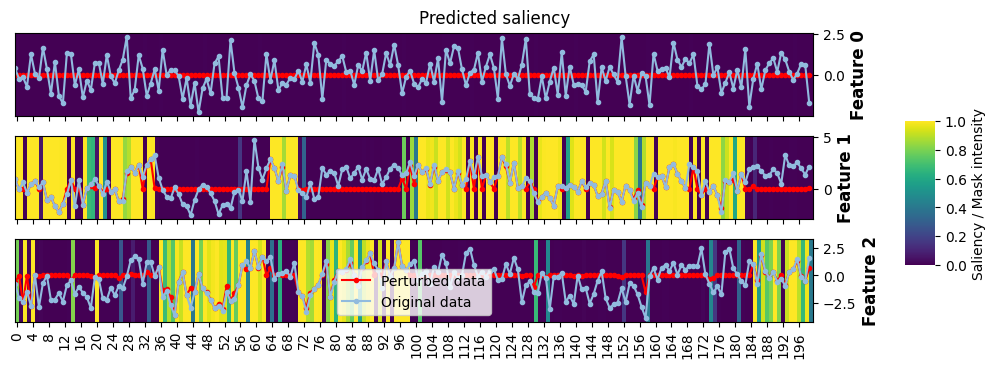

In [19]:
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    mask_hmm[SAL_ID].T,
    suptitle="Predicted saliency",
)

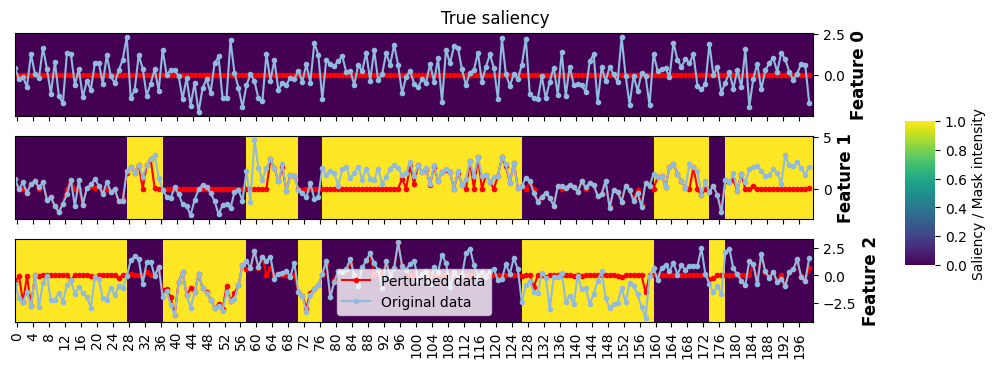

In [20]:
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    true_saliency_hmm[SAL_ID].T,
    suptitle="True saliency",
)

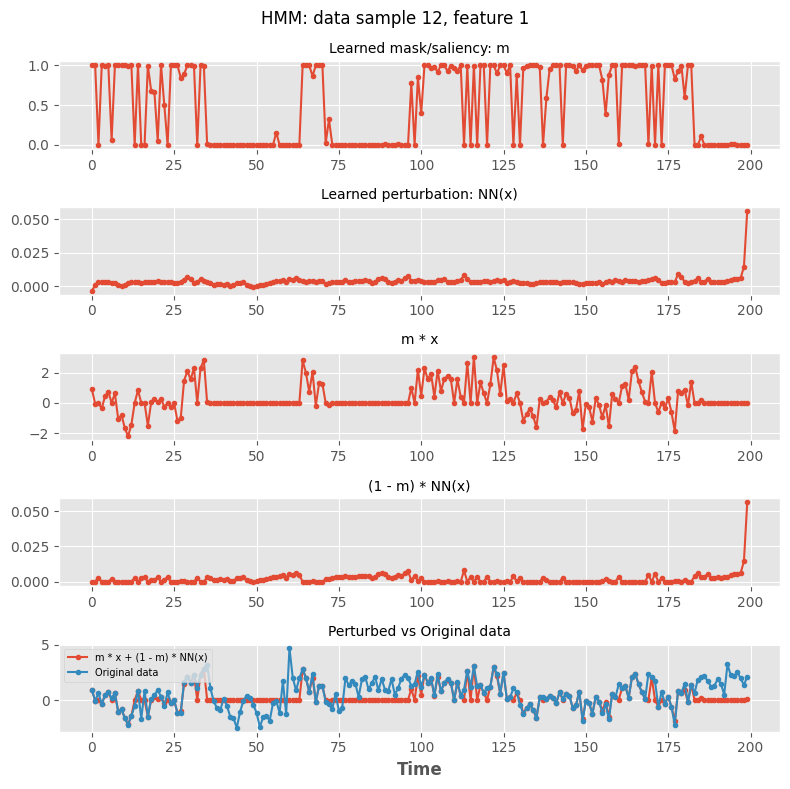

In [21]:
feat_no = 1  # Which specific time series to investigate?
plot_components(
    orig=hmm_batch[SAL_ID].T[feat_no],
    perturbed=x1_hmm[SAL_ID].T[feat_no],
    mask=mask_hmm[SAL_ID].T[feat_no],
    perturbation=perturbation_hmm[SAL_ID].T[feat_no],
    suptitle=f"HMM: data sample {SAL_ID}, feature {feat_no}",
    figsize=(8, 8),
)

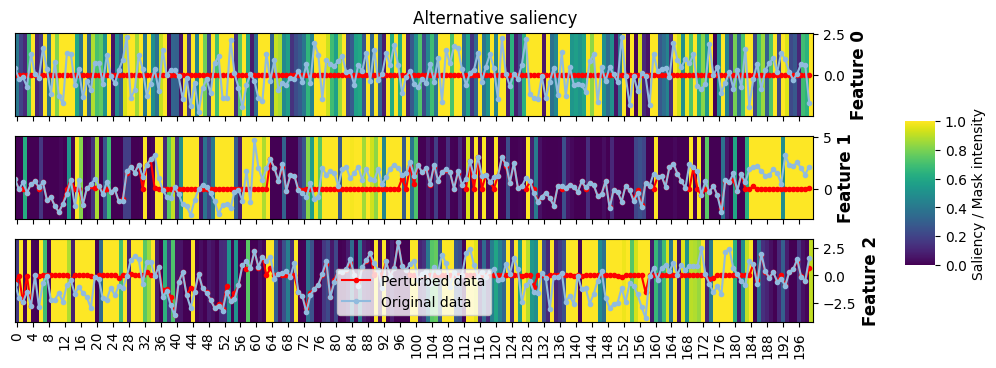

In [22]:
# (1 - m) * |NN(x) - x|
# Intuition: the higher this value, the more perturbed the data is.
alternative = (1 - mask_hmm) * th.abs(perturbation_hmm - hmm_batch)
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    alternative[SAL_ID].T,
    suptitle="Alternative saliency",
)

In [27]:
nn_x = perturbation_hmm[SAL_ID].T[feat_no]
x = hmm_batch[SAL_ID].T[feat_no]
m = mask_hmm[SAL_ID].T[feat_no]
np.corrcoef(m * x, nn_x)

array([[1.        , 0.07235565],
       [0.07235565, 1.        ]])

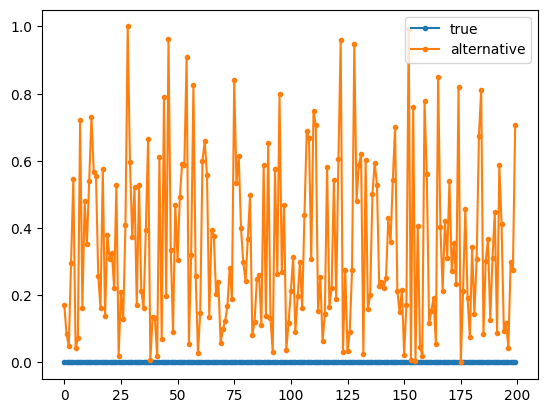

In [34]:
# plot true saliency vs (1 - m) * |NN(x) - x|
alt_spec = alternative_normalized[SAL_ID].T[0]
alternative_normalized = (alt_spec - alt_spec.min()) / (alt_spec.max() - alt_spec.min())
plt.plot(true_saliency_hmm[SAL_ID].T[0], marker=".", label="true")
plt.plot(alternative_normalized, marker=".", label="alternative")
plt.legend()
plt.show()

In [ ]:
# clamping vs normalizing in the paper?? relative importance
# figure 5 - uniform distribution (all points equally important),
# more important to weight the events at the end of the signal